In [84]:
%%capture
%cd drive/MyDrive/NLP\ with\ Disaster

!pip install sentence_transformers==0.3.7
!pip install symspellpy

In [85]:
import os 
import zipfile 

local_zip = "data.zip"

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [86]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import spacy # library for advanced natural languages processing
import regex as re
from sentence_transformers import SentenceTransformer # for sentence embeddings
from sklearn.metrics.pairwise import cosine_similarity # for keyword extraction - to calculate the similarities between keyword candidates and text

import tensorflow as tf

import os
os.system('python -m spacy download en')

nlp = spacy.load('en')

from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell()
dictionary_path = "./frequency_dictionary_en_82_765.txt.txt"
sym_spell.load_dictionary(dictionary_path, 0, 1)

True

In [87]:
train = pd.read_csv("/tmp/train.csv")
test = pd.read_csv("/tmp/test.csv")

In [88]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [89]:
train.sample(5)

,id,keyword,location,text,target
84,121,accident,"South Bloomfield, OH",Accident in #Ashville on US 23 SB before SR 75...,1
1928,2771,curfew,NaN,@aptly_engineerd There is no such curfew.,0
3779,5367,fire%20truck,NaN,#reno Truck trailer catches fire in Reno http:...,1
5512,7865,quarantined,NaN,Officials: Alabama home quarantined over possi...,1
3462,4953,exploded,elizabeth king,oh yeah my ipod almost exploded last night i w...,1


In [90]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [91]:
test.sample(5)

,id,keyword,location,text
130,414,apocalypse,"Akron, Ohio",@ItsKingRiffYall I'm excited for apocalypse re...
1844,6229,hijacker,"Fairfax, VA",Remove the http://t.co/Ytao0lT144 and Linkury ...
3112,10309,weapon,PNW,Slosher is a fucboi weapon
2348,7846,quarantined,"darwins, au",Reddit's new content policy goes into effect m...
2309,7713,panicking,omaha neblastya,I'm panicking like crazy and I need you


In [92]:
train[train['target']==1].size

16355

In [93]:
train[train['target']==0].size

21710

In [94]:
# convert to lower case 
train["keyword"] = train["keyword"].apply(lambda x: str.lower(x) if pd.isna(x) != True else x)
train["location"] = train["location"].apply(lambda x: str.lower(x) if pd.isna(x) != True else x)
train["text"] = train["text"].apply(lambda x: str.lower(x))

test["keyword"] = test["keyword"].apply(lambda x: str.lower(x) if pd.isna(x) != True else x)
test["location"] = test["location"].apply(lambda x: str.lower(x) if pd.isna(x) != True else x)
test["text"] = test["text"].apply(lambda x: str.lower(x))

In [95]:
import re,string

def remove_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

train["keyword"] = train["keyword"].apply(lambda x: remove_entities(x) if pd.isna(x) != True else x)
train["location"] = train["location"].apply(lambda x: remove_entities(x) if pd.isna(x) != True else x)
train["text"] = train["text"].apply(lambda x: remove_entities(x))

test["keyword"] = test["keyword"].apply(lambda x: remove_entities(x) if pd.isna(x) != True else x)
test["location"] = test["location"].apply(lambda x: remove_entities(x) if pd.isna(x) != True else x)
test["text"] = test["text"].apply(lambda x: remove_entities(x))

In [96]:
# remove URL links
train["keyword"] = train["keyword"].apply(lambda x: re.sub(r"(?:\@|http?\://|https?\://|www)\S+",' ', x) if pd.isna(x) != True else x)
train["location"] = train["location"].apply(lambda x: re.sub(r"(?:\@|http?\://|https?\://|www)\S+",' ', x) if pd.isna(x) != True else x)
train["text"] = train["text"].apply(lambda x: re.sub(r"(?:\@|http?\://|https?\://|www)\S+",' ', x))

test["keyword"] = test["keyword"].apply(lambda x: re.sub(r"(?:\@|http?\://|https?\://|www)\S+",' ', x) if pd.isna(x) != True else x)
test["location"] = test["location"].apply(lambda x: re.sub(r"(?:\@|http?\://|https?\://|www)\S+",' ', x) if pd.isna(x) != True else x)
test["text"] = test["text"].apply(lambda x: re.sub(r"(?:\@|http?\://|https?\://|www)\S+",' ', x))

In [97]:
# remove punctuation 
train["keyword"] = train["keyword"].apply(lambda x: re.sub(r'[^\w\s]',' ', x) if pd.isna(x) != True else x)
train["location"] = train["location"].apply(lambda x: re.sub(r'[^\w\s]',' ', x) if pd.isna(x) != True else x)
train["text"] = train["text"].apply(lambda x: re.sub(r'[^\w\s]',' ', x))

test["keyword"] = test["keyword"].apply(lambda x: re.sub(r'[^\w\s]',' ', x) if pd.isna(x) != True else x)
test["location"] = test["location"].apply(lambda x: re.sub(r'[^\w\s]',' ', x) if pd.isna(x) != True else x)
test["text"] = test["text"].apply(lambda x: re.sub(r'[^\w\s]',' ', x))

In [98]:
from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell()

dictionary_path = "./frequency_dictionary_en_82_765.txt.txt"

sym_spell.load_dictionary(dictionary_path, 0, 1)

def spelling_correction(sent): 
  doc_w_correct_spelling = []
  for tok in sent.split(" "):

      x =  sym_spell.lookup(tok, Verbosity.CLOSEST, max_edit_distance=2, include_unknown=True)[0].__str__()
      y = x.split(',')[0]
      doc_w_correct_spelling.append(y)

  return " ".join(doc_w_correct_spelling)

train["keyword"] = train["keyword"].apply(lambda x: spelling_correction(x) if pd.isna(x) != True else x)
train["location"] = train["location"].apply(lambda x: spelling_correction(x) if pd.isna(x) != True else x)
train["text"] = train["text"].apply(lambda x: spelling_correction(x))

test["keyword"] = test["keyword"].apply(lambda x: spelling_correction(x) if pd.isna(x) != True else x)
test["location"] = test["location"].apply(lambda x: spelling_correction(x) if pd.isna(x) != True else x)
test["text"] = test["text"].apply(lambda x: spelling_correction(x))


In [99]:
%%capture

# download the language model
import os
os.system('python -m spacy download en')
nlp = spacy.load('en')

# download pre-trained model for sentence embeddings
model = SentenceTransformer('distilbert-base-nli-mean-tokens') 

def extract_keywords(nlp=nlp, doc="", no_of_keywords=5, model=model):

    doc = doc.lower()
    doc = re.sub(r'(?:\@|http?\://|https?\://|www)\S+',' ', doc)
    doc = re.sub(r'[^\w\s]',' ', doc)
    doc = re.sub(' \d+', ' ', doc)

    doc_ = nlp(doc)

    # costum list of parts-of-speech (pos) tags we are interested in
    pos_tag = ['VERB','NOUN','ADJ','PROPN']
    result=[]
    
    # if the token pos tag matches one of the pos_tag, then add the text form of the token to result list
    for token in doc_:
        if (token.pos_ in pos_tag):
            result.append(token.text)
    
    doc_embedding = model.encode([doc])
    results_embeddings = model.encode(result)
    
    # calculate the similarity between document and results embeddings 
    distances = cosine_similarity(doc_embedding, results_embeddings)

    # get the top similar keywords
    keywords = [result[index] for index in distances.argsort()[0][-no_of_keywords:]]

    return keywords

# fill the empty entries in the train keyword column 
for i in range(len(train["keyword"])): 
    if pd.isnull(train['keyword'].iloc[i]):
        try:
          train['keyword'].iloc[i] = extract_keywords(nlp=nlp, doc=train.text.iloc[i], no_of_keywords=1, model=model)[0]
        except: 
          train['keyword'].iloc[i] = "NaN" # incase of an unexpected error add "NaN"

# fill the empty entries in the train keyword column 
for i in range(len(test["keyword"])): 
    if pd.isnull(test['keyword'].iloc[i]):
        try:
            test['keyword'].iloc[i] = extract_keywords(nlp=nlp, doc=test.text.iloc[i], no_of_keywords=1, model=model)[0]
        except: 
            test['keyword'].iloc[i] = "NaN" # incase of an unexpected error add "NaN"

In [100]:
%%capture

def get_location(nlp=nlp, doc=""): 
    doc_ = nlp(doc)
    
    location = ""
    
    # check the entities labels
    # if they are Geopolitical Entities (GPE) - i.e. country, city, state or Organizations (ORG)
    # append them to the location string
    for ent in doc_.ents: 
        if ent.label_ in ["GPE", "ORG"]: 
            location = location + ent.text + " " 
            
    return location

# fill the empty entries in the train location column 
for i in range(len(train["location"])): 
    if pd.isnull(train['location'].iloc[i]):
        try:
            train['location'].iloc[i] = get_location(nlp=nlp, doc=train.text.iloc[i]) 
        except: 
            test['location'].iloc[i] = "NaN" # incase of an unexpected error add "NaN"

# fill the empty entries in the test location column 
for i in range(len(test["location"])): 
    if pd.isnull(test['location'].iloc[i]):
        try:
            test['location'].iloc[i] = get_location(nlp=nlp, doc=test.text.iloc[i])
        except: 
            test['location'].iloc[i] = "NaN" # incase of an unexpected error add "NaN"

In [101]:
%%capture

def lemmatize(sentence):
    doc = nlp(sentence) # tokenize the text and produce a Doc Object
    lemmas =  [token.lemma_ for token in doc]
    return " ".join(lemmas)

train["keyword"] = train["keyword"].apply(lambda x: lemmatize(x) if pd.isna(x) != True else x)
train["location"] = train["location"].apply(lambda x: lemmatize(x) if pd.isna(x) != True else x)
train["text"] = train["text"].apply(lambda x: lemmatize(x))


test["keyword"] = test["keyword"].apply(lambda x: lemmatize(x) if pd.isna(x) != True else x)
test["location"] = test["location"].apply(lambda x: lemmatize(x) if pd.isna(x) != True else x)
test["text"] = test["text"].apply(lambda x: lemmatize(x))

In [102]:
%%capture

def remove_stopwords(sentence): 
  
    doc = nlp(sentence) # tokenize the text and produce a Doc Object
    all_stopwords = nlp.Defaults.stop_words
    doc_tokens = [token.text for token in doc]
    tokens_without_sw = [word for word in doc_tokens if not word in all_stopwords]
    return " ".join(tokens_without_sw)

train["keyword"] = train["keyword"].apply(lambda x: remove_stopwords(x) if pd.isna(x) != True else x)
train["location"] = train["location"].apply(lambda x: remove_stopwords(x) if pd.isna(x) != True else x)
train["text"] = train["text"].apply(lambda x: remove_stopwords(x))


test["keyword"] = test["keyword"].apply(lambda x: remove_stopwords(x) if pd.isna(x) != True else x)
test["location"] = test["location"].apply(lambda x: remove_stopwords(x) if pd.isna(x) != True else x)
test["text"] = test["text"].apply(lambda x: remove_stopwords(x))

In [103]:
# convert to lowercase 
train["keyword"] = train["keyword"].apply(lambda x: str.lower(x) if pd.isna(x) != True else x)
train["location"] = train["location"].apply(lambda x: str.lower(x) if pd.isna(x) != True else x)
train["text"] = train["text"].apply(lambda x: str.lower(x))

test["keyword"] = test["keyword"].apply(lambda x: str.lower(x) if pd.isna(x) != True else x)
test["location"] = test["location"].apply(lambda x: str.lower(x) if pd.isna(x) != True else x)
test["text"] = test["text"].apply(lambda x: str.lower(x))
# remove tags
train["keyword"] = train["keyword"].apply(lambda x: re.sub(r"(?:\@|http?\://|https?\://|www)\S+",' ', x) if pd.isna(x) != True else x)
train["location"] = train["location"].apply(lambda x: re.sub(r"(?:\@|http?\://|https?\://|www)\S+",' ', x) if pd.isna(x) != True else x)
train["text"] = train["text"].apply(lambda x: re.sub(r"(?:\@|http?\://|https?\://|www)\S+",' ', x))

test["keyword"] = test["keyword"].apply(lambda x: re.sub(r"(?:\@|http?\://|https?\://|www)\S+",' ', x) if pd.isna(x) != True else x)
test["location"] = test["location"].apply(lambda x: re.sub(r"(?:\@|http?\://|https?\://|www)\S+",' ', x) if pd.isna(x) != True else x)
test["text"] = test["text"].apply(lambda x: re.sub(r"(?:\@|http?\://|https?\://|www)\S+",' ', x))
# remove punctuation 
train["keyword"] = train["keyword"].apply(lambda x: re.sub(r'[^\w\s]',' ', x) if pd.isna(x) != True else x)
train["location"] = train["location"].apply(lambda x: re.sub(r'[^\w\s]',' ', x) if pd.isna(x) != True else x)
train["text"] = train["text"].apply(lambda x: re.sub(r'[^\w\s]',' ', x))

test["keyword"] = test["keyword"].apply(lambda x: re.sub(r'[^\w\s]',' ', x) if pd.isna(x) != True else x)
test["location"] = test["location"].apply(lambda x: re.sub(r'[^\w\s]',' ', x) if pd.isna(x) != True else x)
test["text"] = test["text"].apply(lambda x: re.sub(r'[^\w\s]',' ', x) if pd.isna(x) != True else x)

In [104]:
import tensorflow_hub as hub

model = "https://tfhub.dev/google/nnlm-en-dim50/2"
embed = hub.load(model)

In [105]:
from sklearn.utils import shuffle

train = shuffle(train, random_state=42).reset_index(drop=True) # shuffle the train data
y = np.array(train["target"].tolist()) # convert the target column into a numpy array

In [106]:
key_embed = embed(train.keyword.to_list()) # keyword embeddings
loc_embed = embed(train.location.to_list()) # location embeddings
text_embed = embed(train.text.to_list()) # text embeddings 

In [107]:
from tensorflow.keras.layers import Input, Dense, Flatten, concatenate, Dropout
from tensorflow.keras import Model

keyword_input = Input(shape=(key_embed.shape[1],))
location_input = Input(shape=(loc_embed.shape[1],))
text_input = Input(shape=(text_embed.shape[1],))

# create keyword model
key_model = Flatten()(keyword_input)
key_model = Dense(1024, activation='relu')(key_model)
key_model = Dropout(0.5)(key_model)

# create location model
loc_model = Flatten()(location_input)
loc_model = Dense(1024, activation='relu')(loc_model)
loc_model = Dropout(0.5)(loc_model)

# create text model
text_model = Flatten()(text_input)
text_model = Dense(1024, activation='relu')(text_model)
text_model = Dropout(0.5)(text_model)

# concatenate the three models to create the final model
merged = concatenate([key_model,
                        loc_model,
                            text_model], axis=1)

merged = Dense(1024, activation='relu')(merged)
merged = Dropout(0.5)(merged)
final = Dense(1, activation = 'sigmoid')(merged)

final = Model(inputs = [keyword_input, location_input, text_input], outputs=final)

lr = 0.1 # learning rate 
epochs = 100 # number of epochs
opt = tf.keras.optimizers.SGD(lr = lr, momentum = 0.8, decay = lr/epochs) # optimizer

final.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

final.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 50)           0           input_7[0][0]                    
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [108]:
lr = 0.1 # learning rate 
opt = tf.keras.optimizers.SGD(lr = lr, momentum = 0.8, decay = lr/epochs) # optimizer
epochs = 100 # number of epochs

final.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

earlystop = tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', mode = 'min', patience=10, verbose = 1
)

history = final.fit(
            x = [key_embed, loc_embed, text_embed],
            y = y, 
            batch_size = 32, 
            epochs = epochs, 
            validation_split = 0.1,
            callbacks=[earlystop]
)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
215/215 [==============================] - 9s 38ms/step - loss: 0.5479 - accuracy: 0.7276 - val_loss: 0.5255 - val_accuracy: 0.7651
Epoch 2/100
215/215 [==============================] - 8s 37ms/step - loss: 0.4998 - accuracy: 0.7675 - val_loss: 0.5110 - val_accuracy: 0.7822
Epoch 3/100
215/215 [==============================] - 8s 37ms/step - loss: 0.4828 - accuracy: 0.7783 - val_loss: 0.5120 - val_accuracy: 0.7769
Epoch 4/100
215/215 [==============================] - 8s 37ms/step - loss: 0.4719 - accuracy: 0.7881 - val_loss: 0.5033 - val_accuracy: 0.7900
Epoch 5/100
215/215 [==============================] - 8s 38ms/step - loss: 0.4629 - accuracy: 0.7902 - val_loss: 0.4939 - val_accuracy: 0.7874
Epoch 6/100
215/215 [==============================] - 8s 38ms/step - loss: 0.4528 - accuracy: 0.7926 - val_loss: 0.5115 - val_accuracy: 0.7861
Epoch 7/100
215/215 [==============================] - 8s 37ms/step - loss: 0.4425 - accuracy: 0.8009 - val_loss: 0.4891 - val_accuracy:

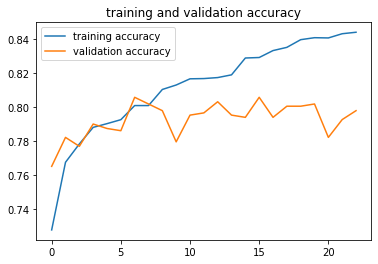

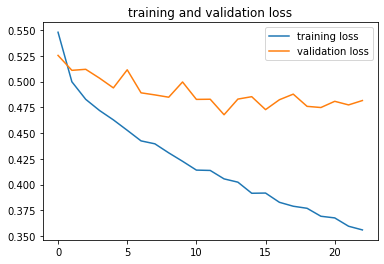

In [109]:
import matplotlib.pyplot as plt

acc=history.history["accuracy"]
loss=history.history["loss"]

val_acc=history.history["val_accuracy"]
val_loss=history.history["val_loss"]

epochs = range(len(acc))

plt.figure()

plt.plot(epochs, acc, label="training accuracy")
plt.plot(epochs, val_acc, label="validation accuracy")
plt.title("training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, label="training loss")
plt.plot(epochs, val_loss, label="validation loss")
plt.title("training and validation loss")
plt.legend()

plt.show()

In [110]:
test_key_embed = embed(test.keyword.to_list()) # keyword embeddings
test_loc_embed = embed(test.location.to_list()) # location embeddings
test_text_embed = embed(test.text.to_list()) # text embeddings 

In [111]:
results = final.predict([test_key_embed, test_loc_embed, test_text_embed])
results = results.tolist()

In [113]:
predictions = [1 if result[0] > 0.5 else 0 for result in results]

In [114]:
test["target_results"] = predictions

In [115]:
test.sample(10)

,id,keyword,location,text,target_results
937,3094,death,,bigamist pron wife charge death pron secon...,1
1090,3590,desolate,los angeles,recall cp2020 australia blight desolate corporate,0
2730,9091,structural failure,swaggdad rock,different material etc close building stay int...,0
2619,8764,siren,lagos,siren good wish boo,0
1738,5862,hailstorm,boston,jplocalfirst pron eliotschool yesterday wow ...,0
3216,10683,wound,worldwide,pron wound easily turn pron people pron ...,0
1527,5086,famine,brooklyn new york,shameful tragic help co 5p1e40qkgv,1
214,696,attack,new delhi india,cop injure gunfight militant attack udhampur p...,1
542,1778,building fire,mighty tempe arizona,failure pron exist pron change direction a...,1
2288,7646,panic,sad,panic sublime rome,0
